### Тестовое задание на вакансию Junior Data Analyst/Engineer. 
Выполнил Кабанов Степан

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
sns.set_theme()

В качестве данных для анализа были взяты последние $10\ 000$ сообщений из чата t.me/aimylogic. Данные охватывают примерно год активности чата: 7 января 2022 - 3 января 2023

In [2]:
data = pd.read_csv('data_10000.csv')

Таблица содержит следующую информацию
- `text`:  текст сообщения, не считая сообщений о событиях чата, таких как исключение/добавление участника и т.д
- `id`:  идентификатор сообщения
- `reply_msg_id`:  индентификатор сообщения, на которое отвечает данное сообщение (если сообщение не является ответом, то равен -1)
- `sender_id`:  идентификатор пользователя, отправившего сообщение
- `added_user`:  если сообщение информирует о том, что добавлен новый участник равен `True`, иначе `False`
- `date`:  время отправления сообщения в формате timestamp 

In [3]:
# добавим столбец datef для удобного представления времени отправления сообщений
data['datef'] = data['date'].apply(lambda x: datetime.fromtimestamp(x))
# проверка, что сообщение является сообщением от пользователя
data['is_msg'] = data['text'].apply(lambda x: 0 if pd.isna(x) else 1)
# проверка, что сообщение является ответом на другое сообщение
data['is_reply'] = data['reply_msg_id'].apply(lambda x: 1 if x != -1 else 0)

In [4]:
data.sample(10)

,text,id,reply_msg_id,sender_id,added_user,date,datef,is_msg,is_reply
2850,NaN,45255,-1,548664418,False,1.659695e+09,2022-08-05 13:26:44,0,0
6790,оплата проходит на другой ветке,40588,-1,359829450,False,1.649804e+09,2022-04-13 01:49:39,1,0
7866,Конечно определяйте в начале сценария канал. П...,39462,39460,190521897,False,1.647172e+09,2022-03-13 14:52:02,1,1
7300,"Не переживайте, все у Айми под контролем. Стор...",40063,40059,190521897,False,1.648058e+09,2022-03-23 20:45:15,1,1
9290,может просто в другом интенте вес больше полу...,37872,37871,217295630,False,1.643712e+09,2022-02-01 13:45:21,1,1
7019,Доброе утро! Перестал работать http запрос к m...,40351,-1,934731500,False,1.649208e+09,2022-04-06 04:27:51,1,0
3028,https://help.aimylogic.com/docs/ru/how-to-crea...,45046,-1,911650186,False,1.658766e+09,2022-07-25 19:18:46,1,0
7295,Спасибо за ответ,40068,40063,350749529,False,1.648058e+09,2022-03-23 21:00:08,1,1
5420,Чтобы вывелся,42125,-1,39373109,False,1.651879e+09,2022-05-07 02:14:44,1,0
5187,которые надо решить,42372,-1,5076362687,False,1.652263e+09,2022-05-11 12:56:53,1,0


Рассмотрим следующие метрики
- количество сообщений в день
- количество реплаев в день
- количество новых участников в день

и посмотрим их динамику во времени

Посмотрим на зависимость от дня недели. Посмотрим в целом изменение метрики в течение года.

Так же было бы интересно посмотреть на наиболее часто встречаемые (значимые) слова в сообщениях, посмотреть на распределение активностей пользователей. (эти показатели будут измеряться не во времени, а по всему имеющемуся объему данных)


In [5]:
# количество сообщений в день
day_group = data.groupby(data.datef.dt.date)
n_msgs = day_group.agg('sum')['is_msg']
# количество реплаев в день
n_repls = day_group.agg('sum')['is_reply']
# количество новых участников в день
n_new = day_group.agg('sum')['added_user']

Посмотрим на ежедневное количество новых сообщений а так же на рост суммарного числа сообщений за период 

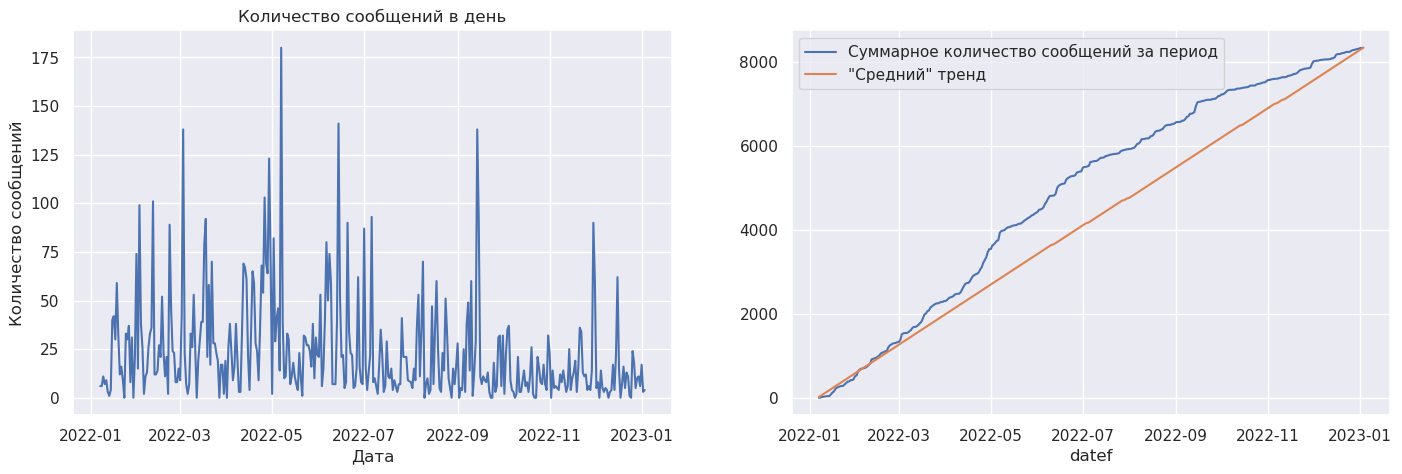

In [6]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(17,5)

n_msgs.plot.line(ax=ax[0],title='Количество сообщений в день')
ax[0].set(xlabel='Дата',ylabel='Количество сообщений')
n_msgs.cumsum().plot.line(ax[1],label='Суммарное количество сообщений за период')
(n_msgs - n_msgs + n_msgs.mean()).cumsum().plot.line(ax[1],label='"Средний" тренд')
plt.legend()
plt.show()

    Тренд "средний" в том смысле, что рост суммарного числа сообщений был бы именно таким, если бы каждый день пользователями отправлялось среднее число сообщений за весь период

**Из графиков можно сделать вывод о том, что чат был активнее в первую половину 2022 года. (2022-01 до 2022-07)**

Попробуем сравнить распределения двух выборок: до и после 2022-07-01. Для этого применим непараметрический критерий Манна-Уитни.

Однако, для его применения нам надо предположить независимость данных внутри выборки, которая почти наверное не имеет места (так как данные представляют собой временной ряд). Однако, как мне кажется, критерий может быть с оговорками применен, чтобы выявить выраженность различия двух выборок (не настаиваю). 

В качестве критического значения возмьем p_value = 0.05

In [7]:
from scipy.stats import mannwhitneyu
from datetime import date
X = n_msgs[n_msgs.index < date(2022, 7, 1)].to_list()
Y = n_msgs[n_msgs.index >= date(2022, 7, 1)].to_list()
mannwhitneyu(X, Y)

MannwhitneyuResult(statistic=21905.0, pvalue=1.8530662928868951e-10)

как и ожидалось, p_value много меньше критического значения -> отклоняем (с большими оговорками) гипотезу об одинаковом распределении, считаем что две выборки значимо различаются.

Аналогично, посмотрим на распределения остальных метрик: *количество реплаев в день* и *количество новых участников в день*. Однако теперь, будем изображать на графиках изменения метрик не сами метрики, а среднее по этим метрикам с окном заданного размера (для лучшей читаемости графиков)

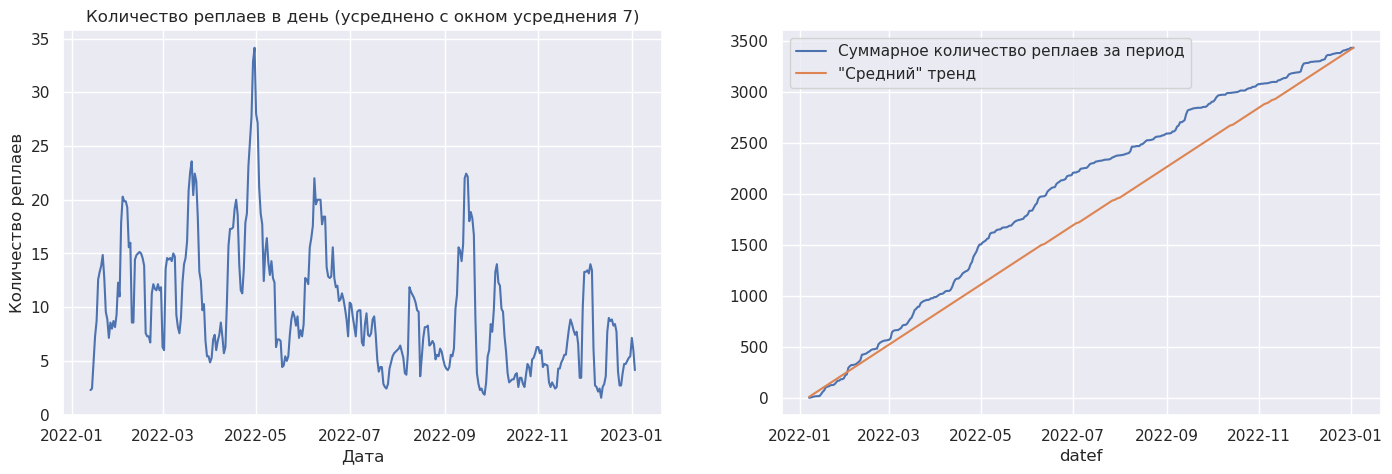

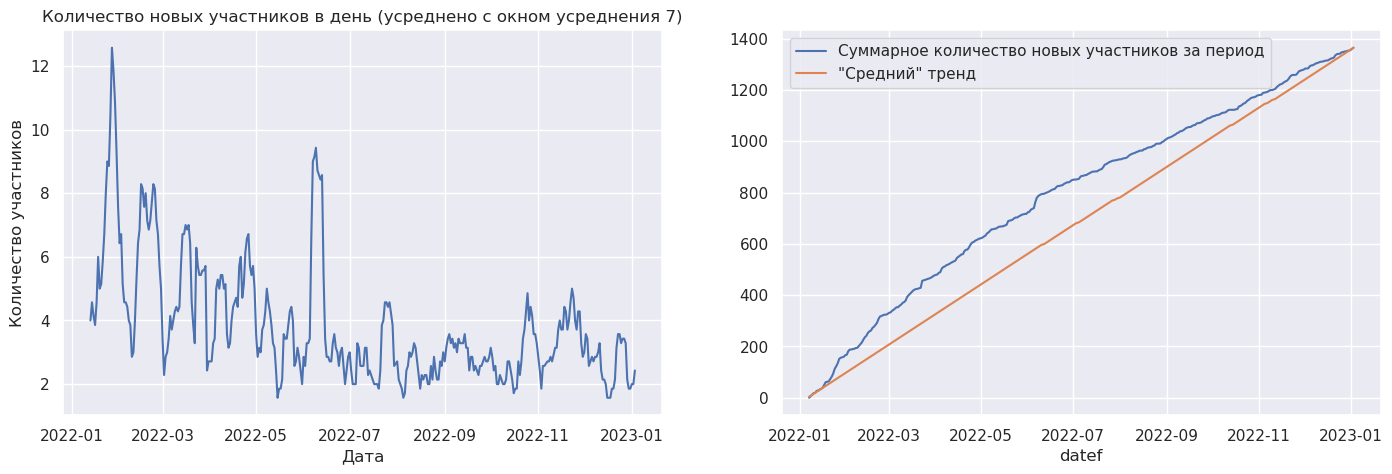

In [8]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(17,5)

WINDOW = 7 # задаем размер окна
n_repls.rolling(WINDOW).mean().plot.line(ax=ax[0],title=f'Количество реплаев в день (усреднено с окном усреднения {WINDOW})')
ax[0].set(xlabel='Дата',ylabel='Количество реплаев')
n_repls.cumsum().plot.line(ax[1],label='Суммарное количество реплаев за период')
(n_repls - n_repls + n_repls.mean()).cumsum().plot.line(ax[1],label='"Средний" тренд')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,2)
fig.set_size_inches(17,5)

n_new.rolling(WINDOW).mean().plot.line(ax=ax[0],title=f'Количество новых участников в день (усреднено с окном усреднения {WINDOW})')
ax[0].set(xlabel='Дата',ylabel='Количество участников')
n_new.cumsum().plot.line(ax[1],label='Суммарное количество новых участников за период')
(n_new - n_new + n_new.mean()).cumsum().plot.line(ax[1],label='"Средний" тренд')

plt.legend()
plt.show()

Видим, что в обоих случаях, судя по "кумулятивным" графикам, **большая часть активности в чате приходится на первое полугодие**.

**Количество участников, кажется, быстрее всего росло в первом квартале 2022 года.**

Взглянем на среднее количество сообщений по дням недели.

In [9]:
# количество сообщений в 
week_group = data.groupby(data.datef.dt.weekday)
week_msgs = week_group.agg('sum')['is_msg']
week_msgs.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# количество реплаев в день
week_repls = week_group.agg('sum')['is_reply']
week_repls.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# количество новых участников в день
week_new = week_group.agg('sum')['added_user']
week_new.index= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_msgs

Monday       1288
Tuesday      1483
Wednesday    1545
Thursday     1499
Friday       1048
Saturday      832
Sunday        653
Name: is_msg, dtype: int64

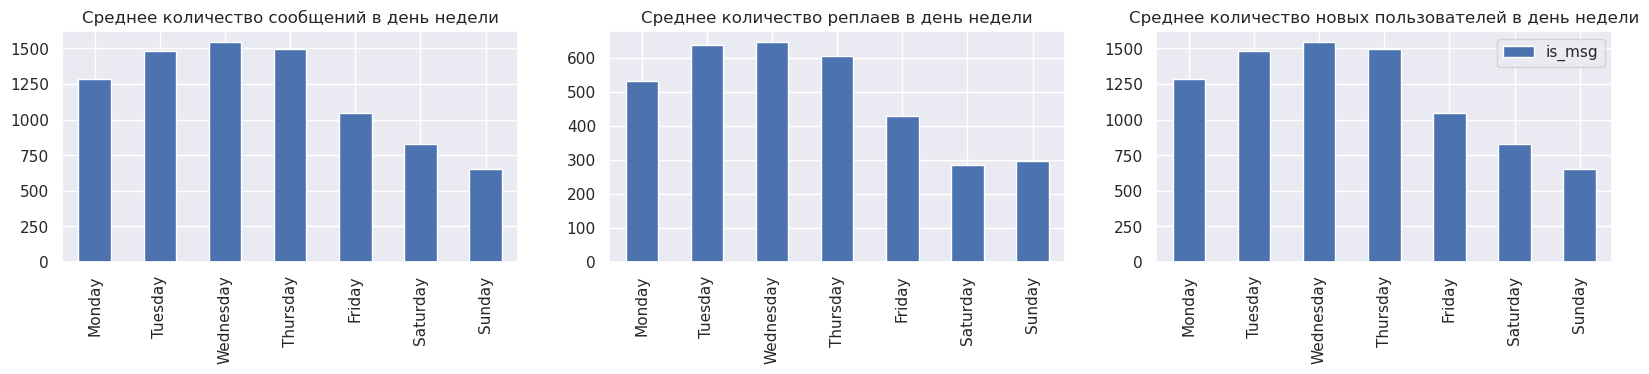

In [10]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,3)
week_msgs.plot.bar(ax=ax[0],title='Среднее количество сообщений в день недели')
week_repls.plot.bar(ax=ax[1],title='Среднее количество реплаев в день недели')
week_msgs.plot.bar(ax=ax[2],title='Среднее количество новых пользователей в день недели')


plt.legend()
plt.show()

Ожидаемые результаты. Люди меньше интересуются чатами, связанными с их работой, во время выходных. **Из интересного, спад активности начинается в пятницу и по всем трем метрикам самый активный день - среда.**

Посмотрим на самые часто встречаемые слова в чате. Постараемся исключить незначимые слова. 

In [11]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')

russian_stopwords = stopwords.words('russian')

[nltk_data] Downloading package punkt to /home/stepa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/stepa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
corpus = ' '.join(data.text.dropna().to_list())
tokens = word_tokenize(corpus)
print(len(tokens))
tokens_ = [w.lower() for w in tokens]
tokens_ = [w for w in tokens_ if w not in russian_stopwords]
tokens_ = [w for w in tokens_ if (w not in string.punctuation and w.isalpha()) or (w == '?')]
print(f'Удалено {len(tokens) - len(tokens_)} токенов')

131017
Удалено 66617 токенов


Решил оставить вопросительный знак, так как количество его появлений можно использовать чтобы оценить метрику "количество заданных вопросов" :)

In [13]:
from collections import Counter
Counter(tokens_).most_common(20)

[('?', 2491),
 ('это', 852),
 ('бот', 419),
 ('бота', 406),
 ('спасибо', 388),
 ('сделать', 367),
 ('привет', 359),
 ('https', 331),
 ('просто', 315),
 ('работает', 304),
 ('нужно', 304),
 ('подскажите', 278),
 ('всем', 259),
 ('добрый', 259),
 ('день', 244),
 ('пожалуйста', 222),
 ('вопрос', 219),
 ('aimylogic', 189),
 ('здравствуйте', 188),
 ('блок', 183)]

Самые частотные слова отвечают тематике чата. Люди обращаются в чат за помощью с созданием ботов с помощью Aimylogic. **Пользователи задали примерно 2.5к вопросов** (приблизительно, так как мы учитываем только тех, кто ставит знак вопроса)

Теперь посмотрим на распределение активностей пользователей. В качестве оценки активности будем брать количество отправленных пользователем сообщений. 

Назовем пользователя *активным*, если он оставил хотя бы одно сообщение

/home/stepa/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


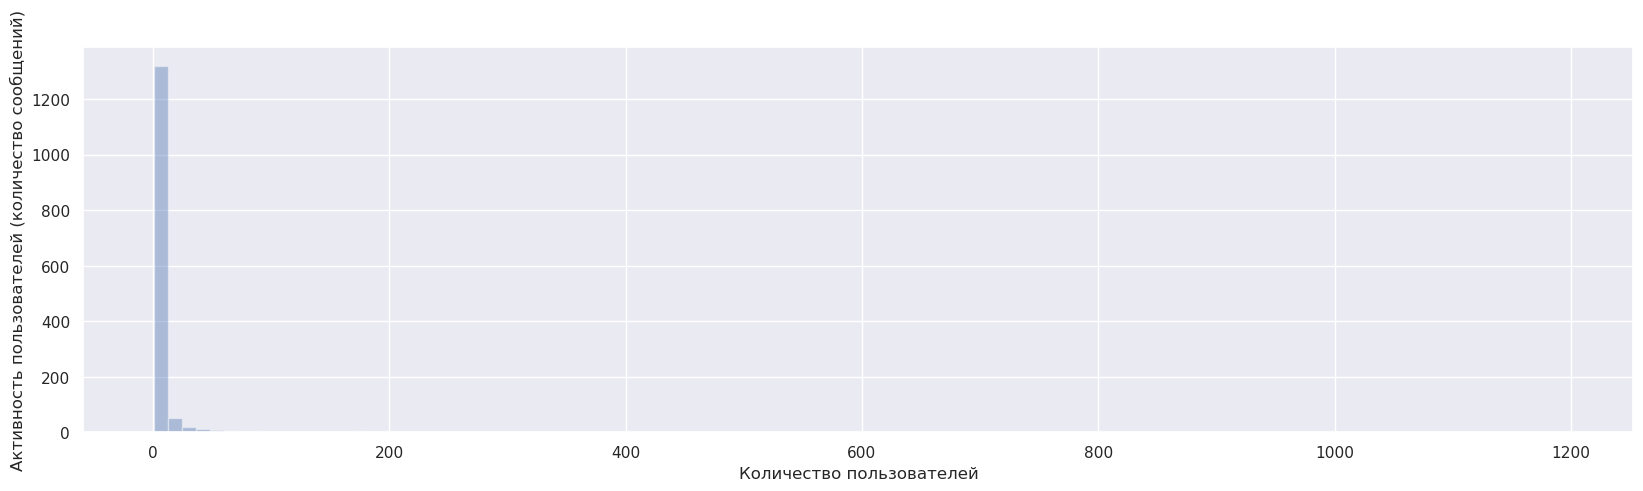

In [14]:
d = data.groupby('sender_id').count()['id']

plt.figure(figsize=(20,5))
sns.distplot(d[d>0],hist=True,kde=False,bins=100)
plt.xlabel('Количество пользователей')
plt.ylabel('Активность пользователей (количество сообщений)')
plt.show()

Есть малое количество пользователей, которое оставляет очень много сообщений. На графике их не разглядеть из-за большого количества пользователей, оставивших совсем немного сообщений. Посмотрим на распределение тех пользователей, которые оставили меньше 100 сообщений и больше 0 сообщений, а потом больше 1 сообщения

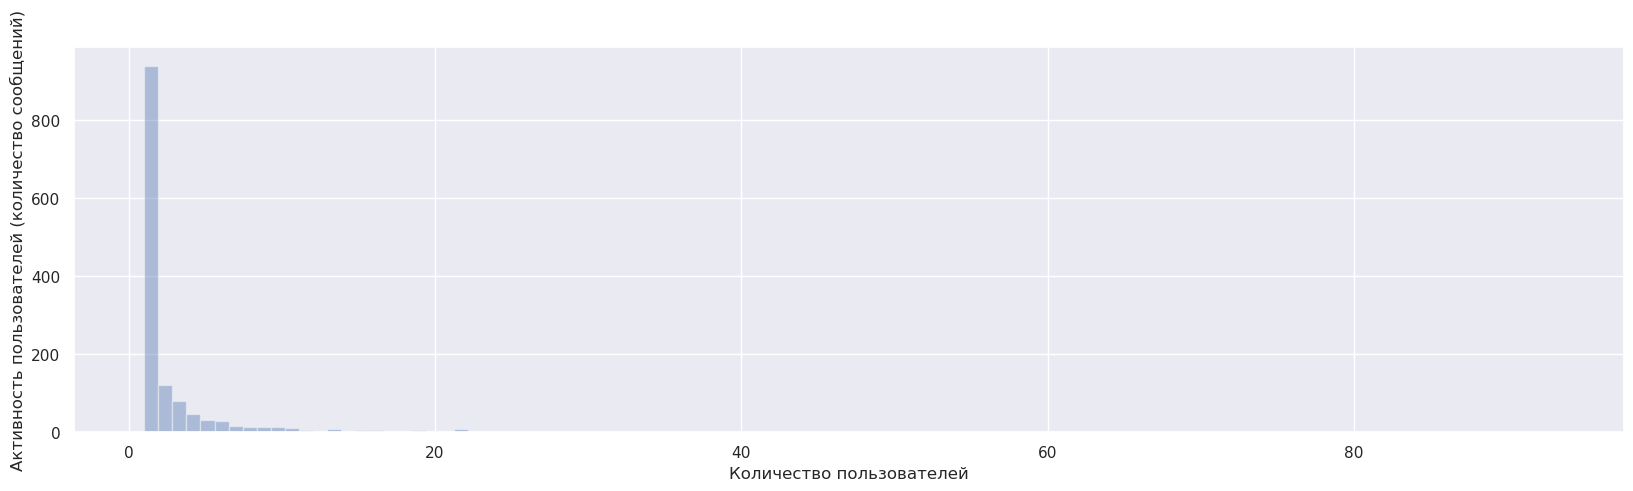

In [15]:
plt.figure(figsize=(20,5))
sns.distplot(d[(d>0) & (d<100)],hist=True,kde=False,bins=100)
plt.xlabel('Количество пользователей')
plt.ylabel('Активность пользователей (количество сообщений)')
plt.show()

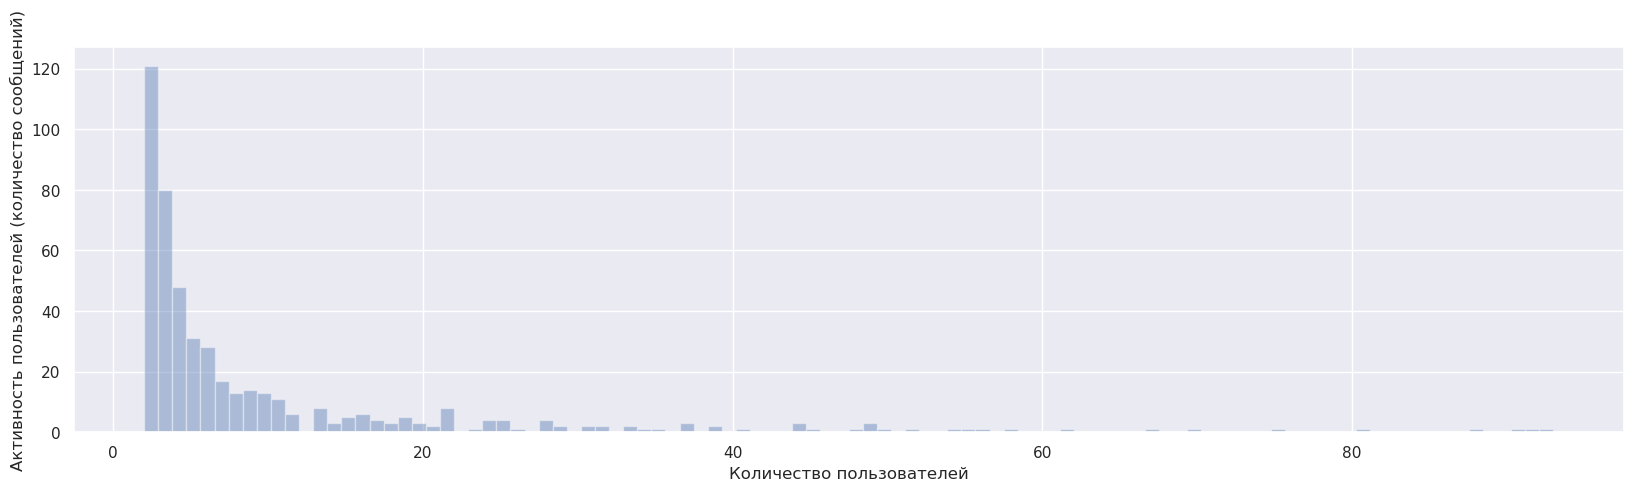

In [16]:
plt.figure(figsize=(20,5))
sns.distplot(d[(d>1) & (d<100)],hist=True,kde=False,bins=100)
plt.xlabel('Количество пользователей')
plt.ylabel('Активность пользователей (количество сообщений)')
plt.show()

Сравнивая два графика распределений, **видим, что подавляющее число активных пользователей оставляет 1 сообщение.** В целом, ожидаемый результат. 